In [1]:
import json
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from glob import glob
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
len_rs, len_ts = [], []
span_rs, span_ts = [], []
for item in glob('rumor/*.json'):
    data = json.load(open(item))
    len_rs.append(len(data))
    span_rs.append(int(data[-1]['t']) - int(data[0]['t']))
for item in glob('truth/*.json'):
    data = json.load(open(item))
    len_ts.append(len(data))
    span_ts.append(int(data[-1]['t']) - int(data[0]['t']))

KeyboardInterrupt: 

In [7]:
raw = np.load('data/prop_graph.npz')

In [4]:
raw2 = np.load('data/prop_span.npz')

In [8]:
samples = glob('rumor/*.json') + glob('truth/*.json')

In [9]:
er, et = [], []
tr, tt = [], []
for item in samples:
    if 'rumor' in item:
        er.append(raw[item].shape[0])
        tr.append(raw[item][-1][0])
    else:
        et.append(raw[item].shape[0])
        tt.append(raw[item][-1][0])

In [10]:
np.sum(er), np.sum(et)

(2090743, 1661716)

In [11]:
np.sum(er) / 2313, np.sum(et) / 2351

(903.9096411586684, 706.8124202467035)

In [12]:
np.max(er), np.max(et), np.min(er), np.min(et)

(59318, 52157, 10, 10)

In [14]:
np.max(tr), np.max(tt), np.min(tr), np.min(tt), np.sum(tr) / 2313, np.sum(tt) / 2351

(123524203, 121134650, 196, 88, 9018915.881539127, 4044508.5146746067)

In [5]:
mx = 0
for item in (glob('rumor/*.json') + glob('truth/*.json')):
    assert raw[item].shape[0] == raw2[item].shape[0]

In [6]:
print(np.max(len_rs), np.min(len_rs), np.max(len_ts), np.min(len_ts))
print(np.max(span_rs), np.max(span_ts))

ValueError: zero-size array to reduction operation maximum which has no identity

NameError: name 'len_rs' is not defined

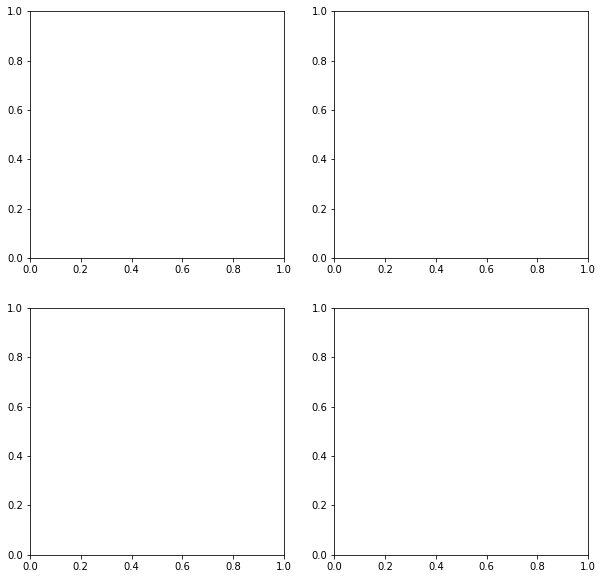

In [22]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
sns.distplot(len_rs, kde=False, ax=axes[0][0])
sns.distplot(len_ts, kde=False, ax=axes[1][0])
sns.distplot(span_rs, kde=False, ax=axes[0][1])
sns.distplot(span_ts, kde=False, ax=axes[1][1])
axes[0][0].set_xlim(0, 5000)
axes[1][0].set_xlim(0, 5000)
axes[0][0].spines['top'].set_visible(False)

In [61]:
len(rsample), len(tsample)

(4, 4)

In [5]:
rsp = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsp = np.random.choice(glob('truth/*.json'), size=4, replace=False)

In [3]:
def lin_graph(sp):
    data = raw[sp]
    src, dst = defaultdict(list), defaultdict(list)
    for t, lx, ly, x, y in data:
        dst[ly].append(t)
    return dst

In [94]:
def log_graph(sp, step=100):
    data = raw[sp]
    dst = defaultdict(list)
    for t, lx, ly, x, y in data:
        dst[ly].append(np.log10(t + 1) * step / 8.1)
    return dst

In [46]:
print(rsp, tsp)

['rumor/3530423067768377.json' 'rumor/3571402777000146.json'
 'rumor/3569846765439099.json' 'rumor/3503918791049877.json'] ['truth/3912107630395265.json' 'truth/3909084371985775.json'
 'truth/3909868647669482.json' 'truth/3919005561171297.json']


In [53]:
src, dst = lin_graph(rsp[0])
print(src.keys(), dst.keys())

dict_keys([0, 1, 2, 3, 4, 5]) dict_keys([0, 1, 2, 3, 4, 5])


['rumor/3484520085121839.json' 'rumor/3529673642807596.json'
 'rumor/3587929294833069.json' 'rumor/3475816099213996.json']
['truth/3504442924082177.json' 'truth/3914961417767122.json'
 'truth/3918240377832625.json' 'truth/3909205159800467.json']


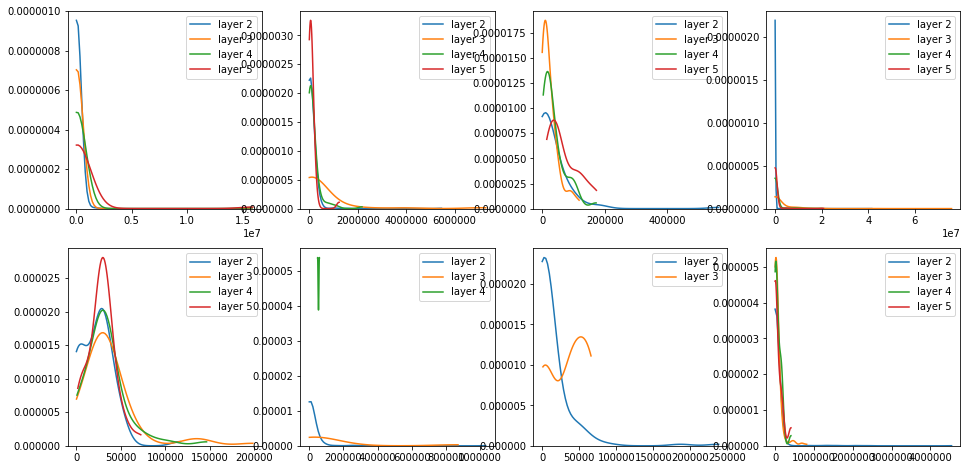

In [93]:
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    rdst = lin_graph(rsp[i])
    tdst = lin_graph(tsp[i])
    for j in range(4):
        if j + 2 in rdst and len(rdst[j+2]) > 1:
            sns.kdeplot(rdst[j+2], bw=0.5, ax=axes[0][i], label=f'layer {j+2}')
        if j + 2 in tdst and len(tdst[j+2]) > 1:
            sns.kdeplot(tdst[j+2], bw=0.5, ax=axes[1][i], label=f'layer {j+2}')
plt.legend()
print(rsp)
print(tsp)

['rumor/3601362552599896.json' 'rumor/3539490741912632.json'
 'rumor/3574604649528092.json' 'rumor/3523113511584631.json']
['truth/3914903520061513.json' 'truth/3907550132596436.json'
 'truth/3910536557540227.json' 'truth/3918235499669365.json']


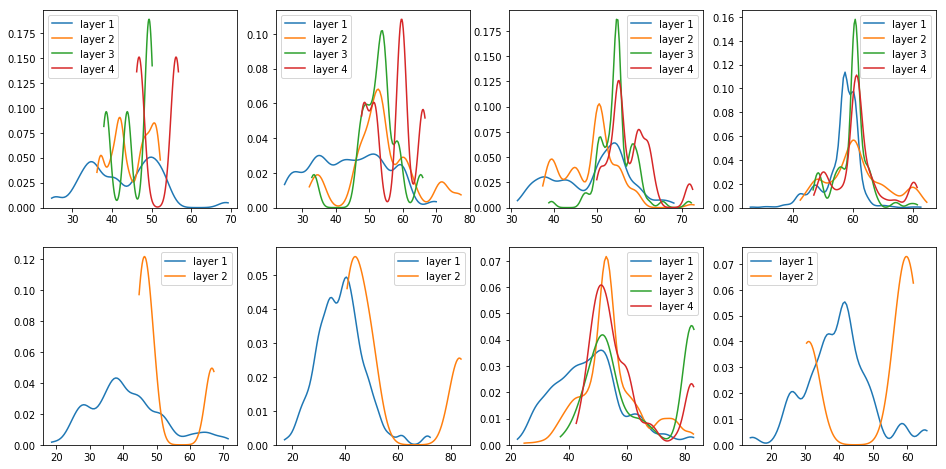

In [105]:
rsp = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsp = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i in range(4):
    rdst = log_graph(rsp[i], 100)
    tdst = log_graph(tsp[i], 100)
    for j in range(4):
        if j + 2 in rdst and len(rdst[j+2]) > 1:
            sns.kdeplot(rdst[j+2], bw=0.2, ax=axes[0][i], label=f'layer {j+1}')
        if j + 2 in tdst and len(tdst[j+2]) > 1:
            sns.kdeplot(tdst[j+2], bw=0.2, ax=axes[1][i], label=f'layer {j+1}')
        
plt.legend()
print(rsp)
print(tsp)

['rumor/3553863182928051.json' 'rumor/3476786354136193.json'
 'rumor/3559315678191265.json' 'rumor/3489942821335796.json']
['truth/3530782356144891.json' 'truth/3909739769052360.json'
 'truth/3911202792746534.json' 'truth/3914934326947009.json']


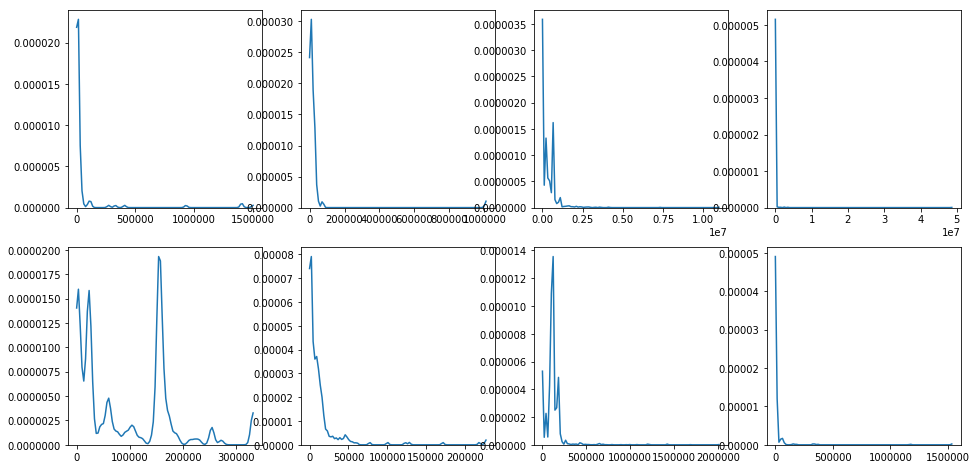

In [71]:
rsample = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsample = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    x = []
    begin = int(data[0]['t'])
    for post in data:
        x.append(int(post['t']) - begin)
    sns.kdeplot(x, bw=0.05, ax=axes[0][i])
    #axes[0][i].set_xlim(0, 50000)
for i, item in enumerate(tsample):
    data = json.load(open(item))
    x = []
    begin = int(data[0]['t'])
    for post in data:
        x.append(int(post['t']) - begin)
    sns.kdeplot(x, bw=0.05, ax=axes[1][i])
print(rsample)
print(tsample)

In [72]:
def lin_volumn(data, step=1000):
    begin = int(data[0]['t'])
    span = list(map(lambda x: int(x['t']) - begin, data))
    period = span[-1] / step
    volumn = list(map(lambda x: int(x / period) - 1, span))
    return volumn

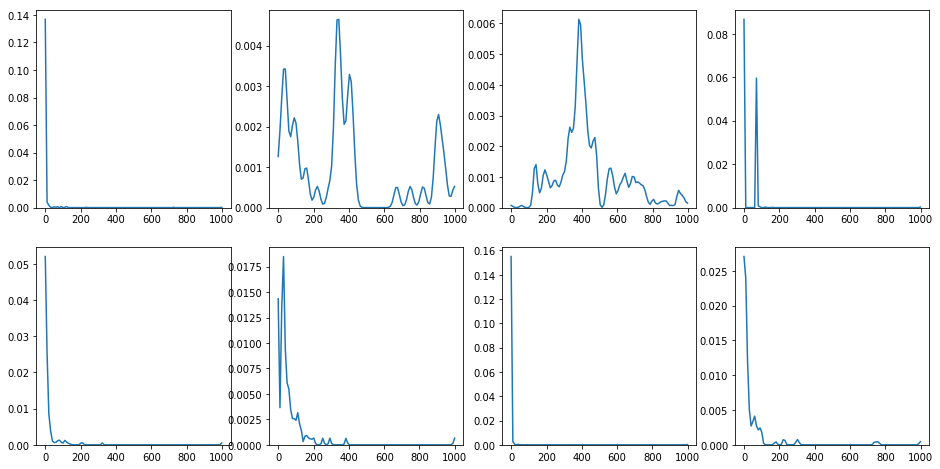

In [73]:
rsample = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsample = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    volumn = lin_volumn(data)
    sns.kdeplot(volumn, bw=0.05, ax=axes[0][i])
for i, item in enumerate(tsample):
    data = json.load(open(item))
    volumn = lin_volumn(data)
    sns.kdeplot(volumn, bw=0.05, ax=axes[1][i])

In [74]:
def log_volumn(data, step=100):
    begin = int(data[0]['t'])
    span = list(map(lambda x: max(0, int(x['t']) - begin) + 1, data))
    try:
        volumn = list(map(lambda x: int(x * step / 8.1), np.log10(span)))
    except:
        print(span)
        return None
    return volumn

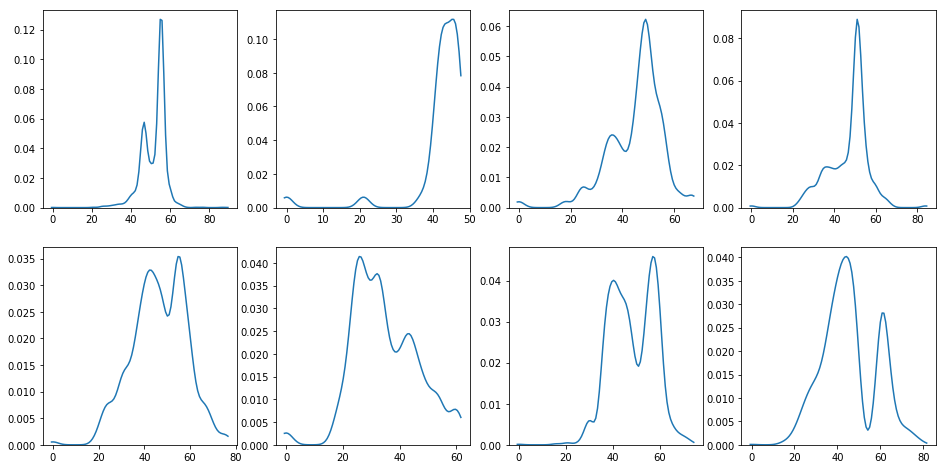

In [84]:
rsample = np.random.choice(glob('rumor/*.json'), size=4, replace=False)
tsample = np.random.choice(glob('truth/*.json'), size=4, replace=False)
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    sns.kdeplot(volumn, bw=0.2, ax=axes[0][i])
for i, item in enumerate(tsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    sns.kdeplot(volumn, bw=0.2, ax=axes[1][i])

In [10]:
rsample = glob('rumor/*.json')
tsample = glob('truth/*.json')
#f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, item in enumerate(rsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    #sns.kdeplot(volumn, bw=0.2, ax=axes[0][i])
for i, item in enumerate(tsample):
    data = json.load(open(item))
    volumn = log_volumn(data)
    #sns.kdeplot(volumn, bw=0.2, ax=axes[1][i])

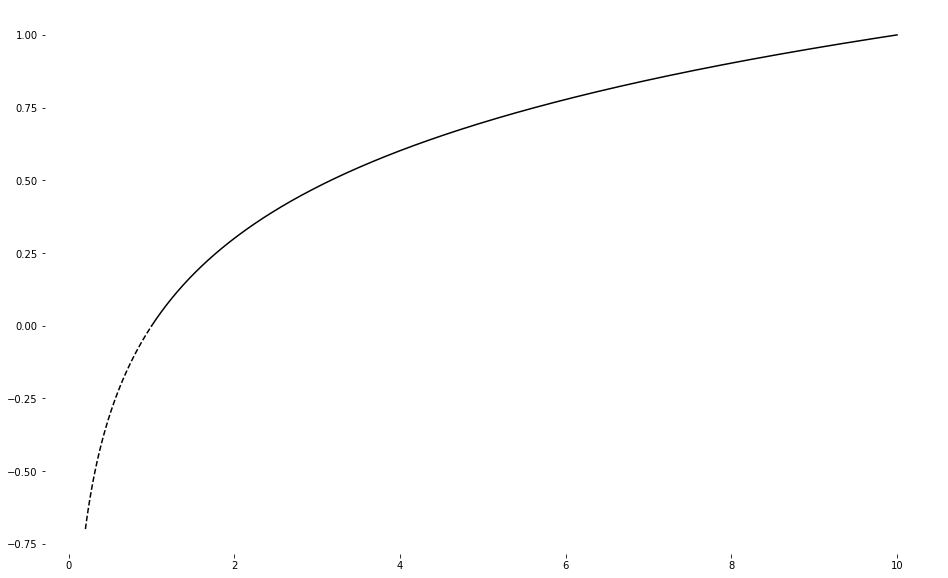

In [27]:
x1 = np.linspace(0.2, 1, 100)
x2 = np.linspace(1, 10, 1000)
plt.figure(figsize=(16,10))
plt.plot(x1, np.log10(x1), 'k--')
plt.plot(x2, np.log10(x2), 'k')
ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.savefig('test.png', dpi=200)

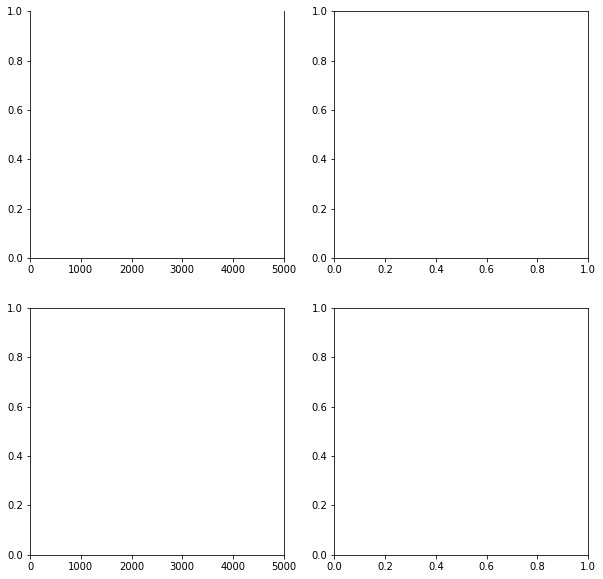

In [23]:
f, axes = plt.subplots(2, 2, figsize=(10, 10))
axes[0][0].set_xlim(0, 5000)
axes[1][0].set_xlim(0, 5000)
axes[0][0].spines['top'].set_visible(False)

In [18]:
ans = defaultdict(list)
for item in glob('rumor/*.json'):
    ret = lin_graph(item)
    for i in range(2, 8):
        ans[i].append(len(ret[i]))

In [19]:
r = [None, None] * 8
for i in range(2, 8):
    r[i] = np.array(ans[i])

In [20]:
print('mean')
for i in range(1, 7):
    print(np.mean(r[i+1]))
print('std')    
for i in range(1, 7):
    print(np.std(r[i+1]))
print('max')
for i in range(1, 7):
    print(np.max(r[i+1]))
print('min')
for i in range(1, 7):
    print(np.min(r[i+1]))
print('cnt')
for i in range(1, 7):
    print(np.count_nonzero(r[i+1]))

mean
496.2611327280588
228.6290531776913
81.41115434500648
40.97535667963683
22.570687418936448
12.87073065283182
std
2123.145206882858
825.1936532606112
273.1658782804518
176.10429984850506
98.33845903809252
56.81337668363675
max
39608
17537
4825
4938
1997
1136
min
0
0
0
0
0
0
cnt
2312
2245
2163
1923
1589
1268


In [17]:
ans = defaultdict(list)
for item in glob('truth/*.json'):
    ret = lin_graph(item)
    for i in range(2, 8):
        ans[i].append(len(ret[i]))
t = [None, None] * 8
for i in range(2, 8):
    t[i] = np.array(ans[i])
print('mean')
for i in range(1, 7):
    print(np.mean(t[i+1]))
print('std')    
for i in range(1, 7):
    print(np.std(t[i+1]))
print('max')
for i in range(1, 7):
    print(np.max(t[i+1]))
print('min')
for i in range(1, 7):
    print(np.min(t[i+1]))
print('cnt')
for i in range(1, 7):
    print(np.count_nonzero(t[i+1]))

mean
549.2356444066355
110.93960017014037
23.335601871544025
8.607826456826881
4.2624415142492555
2.9230114844746917
std
1351.793780229642
519.5864564011966
91.10402346962297
41.889467972354204
26.53286264868911
32.06962242873602
max
29560
19377
2478
940
605
1190
min
2
0
0
0
0
0
cnt
2351
2099
1486
972
613
419
